<a href="https://colab.research.google.com/github/Rahamatunnisa1121/Industrial-Monitoring/blob/main/Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# **Preprocessing Data**

In [3]:
# Load the dataset
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Dataset shape and info
print(f"Shape: {df.shape}")
df.info()

Shape: (10000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
# Drop unnecessary columns
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for null values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [6]:
# Encode 'Type' column
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

# Map 'Failure Type' column to numerical labels
failure_mapping = {
    'No Failure': 0,
    'Heat Dissipation Failure': 1,
    'Power Failure': 2,
    'Overstrain Failure': 3,
    'Tool Wear Failure': 4,
    'Random Failures': 5
}
df['Failure Type'] = df['Failure Type'].map(failure_mapping)

df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,0,True,False
2,298.1,308.5,1498,49.4,5,0,0,True,False
3,298.2,308.6,1433,39.5,7,0,0,True,False
4,298.2,308.7,1408,40.0,9,0,0,True,False


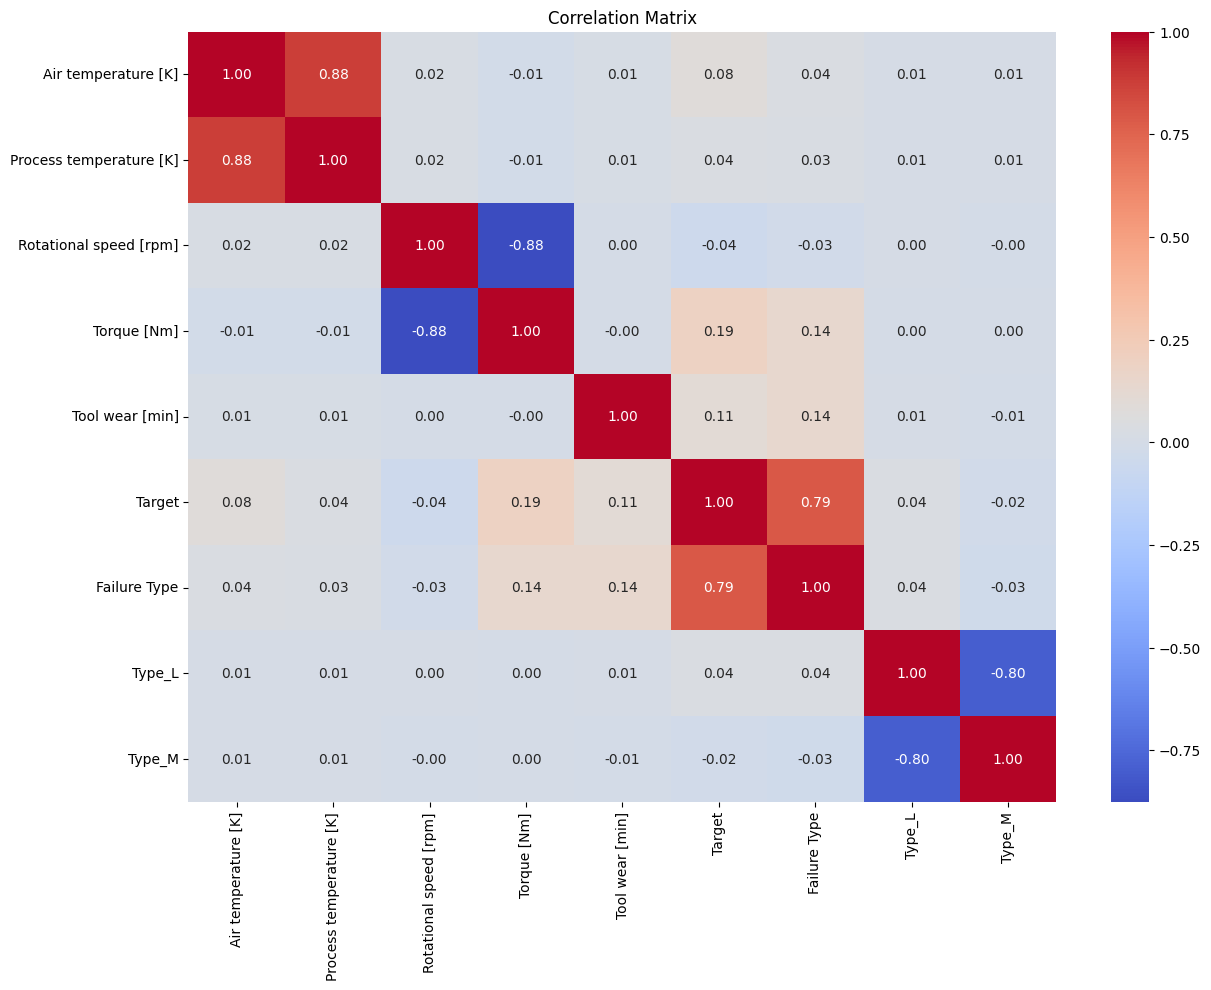

In [7]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
X = df.drop('Failure Type', axis=1)
y = df['Failure Type']

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"Reduced features after PCA: {X_pca.shape[1]}")

Original features: 8
Reduced features after PCA: 6


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# **Training the model**

In [12]:
!pip install xgboost

In [13]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Convert data to DMatrix format (optional but efficient)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# You can also skip DMatrix and just use model.fit()

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 6,
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 42
}

# Train the model
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtest, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)

Accuracy: 0.9895

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       0.78      0.82      0.80        22
           2       0.74      0.74      0.74        19
           3       0.69      0.69      0.69        16
           4       0.75      0.67      0.71         9
           5       0.00      0.00      0.00         4

    accuracy                           0.99      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.99      0.99      0.99      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


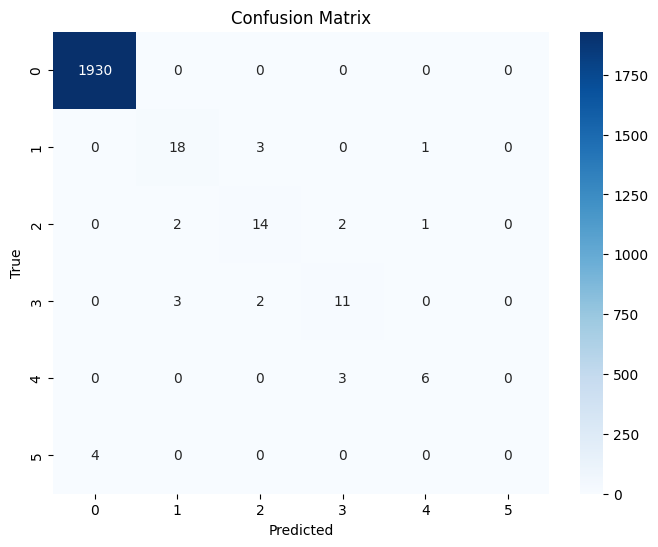

In [15]:
# Predict on test set
y_pred = xgb_model.predict(dtest)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
import joblib

# Save model
joblib.dump(xgb_model, 'xgboost_model.json')  # You can also use model.save_model()

# Save scaler & pca
joblib.dump(scaler, 'scaler.pkl')
if pca:
    joblib.dump(pca, 'pca.pkl')


In [17]:
print("Best iteration:", xgb_model.best_iteration)


Best iteration: 64


# **AI chatbot**

In [18]:
failure_remedies = {
    0: "✅ Machine is operating normally. No immediate action needed.",
    1: "⚠️ Heat failure detected. Check coolant levels, ventilation, and fan systems.",
    2: "🛢️ Overstrain failure detected. Inspect load limits, reduce pressure, check belts and torque.",
    3: "🧯 Power failure detected. Inspect power supply units, battery backups, and cabling.",
    4: "⚙️ Tool wear detected. Perform tool maintenance or replacement immediately.",
    5: "❓ Random failure. Run full diagnostics to determine root cause. May require manual inspection."
}


In [21]:
feature_order = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Type_H', 'Type_L', 'Type_M'
]


In [24]:
import numpy as np
import joblib
import xgboost as xgb

# Load models
model = xgb.Booster()
model = joblib.load("xgboost_model.json") # Ensure you've saved it using model.save_model()
scaler = joblib.load("scaler.pkl")
pca = joblib.load("pca.pkl")  # Or set pca = None if not used

# Remedy dictionary
failure_remedies = {
    0: "✅ Machine is operating normally. No immediate action needed.",
    1: "⚠️ Heat failure detected. Check coolant levels, ventilation, and fan systems.",
    2: "🛢️ Overstrain failure detected. Inspect load limits, reduce pressure, check belts and torque.",
    3: "🧯 Power failure detected. Inspect power supply units, battery backups, and cabling.",
    4: "⚙️ Tool wear detected. Perform tool maintenance or replacement immediately.",
    5: "❓ Random failure. Run full diagnostics to determine root cause. May require manual inspection."
}

def ai_chatbot_response(sensor_data):
    """
    sensor_data: list of 8 values, ordered as:
      [temp, proc_temp, rpm, torque, wear, type_H, type_L, type_M]
    """
    # Reshape to 2D array
    sensor_data = np.array(sensor_data).reshape(1, -1)

    # Scale
    data_scaled = scaler.transform(sensor_data)

    # PCA if used
    if pca:
        data_scaled = pca.transform(data_scaled)

    # Predict
    dmatrix = xgb.DMatrix(data_scaled)
    prediction = int(model.predict(dmatrix)[0])

    return {
        "predicted_class": prediction,
        "status": failure_remedies[prediction]
    }


In [25]:
sample_input = [300, 315, 1450, 42.5, 245, 1, 0, 0]  # Replace with real sensor data

result = ai_chatbot_response(sample_input)
print(f"Predicted Failure Class: {result['predicted_class']}")
print("AI Advice:", result['status'])


Predicted Failure Class: 4
AI Advice: ⚙️ Tool wear detected. Perform tool maintenance or replacement immediately.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
